# **Extract TCC Rasters to Validation Pixels**

Heavily updated to handle TCC time series on AWS s3  

TODO: needs organiztion and cleaning  

Original notes:  
Take in points from a .CSV file, for each point loop through a tiled raster GPKG to identify tiled raster over point, and loop through rasters to extract point to data table. 
Workflow is suspected to be something like this.
1) Identify raster data and run footprint to return a geopackage file.
2) Intersect input points with this footprint to get path to raster intersecting points
3) Loop through tiles that coincide with points of interest, extract values over points, append to data table containing all points. 

Step 1 may be executed outside of this notebook as Paul may just run a previous geopackage code.

#### Notes as of 2022 07 26:
- May want to create a separate gdf that just stores raster paths. Can likely be linked by index value in the point gdf.
- May need to implement multiband support. This would work well if all tiled rasters are in the same tiling scheme. A VRT could be created for each tile of all rasters wanted.
- Minor changes may need to be made to column names to work with Elizabeth's point file  

#### Notes on 2023 12 14:  
- Miesner Height validation data are here: https://doi.pangaea.de/10.1594/PANGAEA.943547

In [ ]:
#!pip install -U rasterstats
#!pip install -U -r /projects/code/icesat2_boreal/dps/requirements_main.txt

In [4]:
!pip install contextily

  Using cached contextily-1.6.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached contextily-1.6.0-py3-none-any.whl (17 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)


In [144]:
from pathlib import Path
import geopandas as gpd
import numpy as np
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd
import pyproj
import shapely

import glob
import os
import random 
import shutil
import time
import itertools

import rasterio as rio
from rasterio.coords import BoundingBox
from rasterio.coords import disjoint_bounds

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import multiprocessing as mp
import contextily as ctx

import rasterstats
from rasterstats import point_query

In [145]:
import warnings
warnings.filterwarnings('ignore')

## Prepare raster footprints before extraction

In [146]:
boreal_tiles = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg')

In [147]:
DICT_FOOTPRINT_Htc2020 = {
    'PRODUCT_DESC': 'Boreal Height from L30 c2020',
    'PRODUCT_NAME': 'Ht_L30_2020',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/Ht_L30_2020/local_training_full/HT_tindex_master.csv'
}
DICT_FOOTPRINT_AGBc2020v2022 = {
    'PRODUCT_DESC': 'Boreal AGB from L30 c2020 (v2022)',
    'PRODUCT_NAME': 'AGB_L30_2020-v2022',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/winter2023/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGBc2020v2023 = {
    'PRODUCT_DESC': 'Boreal AGB from L30 c2020 (v2023-local training)',
    'PRODUCT_NAME': 'AGB_L30_2020-v2023-local-training',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/lduncanson/DPS_tile_lists/BOREAL_MAP/boreal_agb_2023_v3/AGB_L30_2020/local_training_full/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_Ht2019 = {
    'PRODUCT_DESC': 'Boreal Height from H30 2019 with ATL08 v6',
    'PRODUCT_NAME': 'Ht_H30_2019',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/Ht_H30_2019/2019_fullboreal_2019lidar/HT_tindex_master.csv'
}
DICT_FOOTPRINT_Ht2020 = {
    'PRODUCT_DESC': 'Boreal Height from H30 2020 with ATL08 v6',
    'PRODUCT_NAME': 'Ht_H30_2020',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/Ht_H30_2020/atl08_v6_fullboreal_min5000_90p_local/HT_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2019 = {
    'PRODUCT_DESC': 'Boreal AGB from H30 2019 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2019',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2019/2019_fullboreal_2019lidar/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2020 = {
    'PRODUCT_DESC': 'Boreal AGB from H30 2020 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2020',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2020/atl08_v6_fullboreal_min5000_90p_local/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2021 = {
    'PRODUCT_DESC': 'Boreal AGB from H30 2021 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2021',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2021/2021_fullboreal_2021lidar/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2022 = {
    'PRODUCT_DESC': 'Boreal AGB from H30 2022 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2022',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2022/2022_fullboreal_2022lidar/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2023 = {
    'PRODUCT_DESC': 'Boreal AGB from H30 2019 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2023',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v5/AGB_H30_2023/2023_full_2023lidar/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_AGB2020_v2 = {
    'PRODUCT_DESC': 'Boreal AGBv2 from H30 2020 with ATL08 v6',
    'PRODUCT_NAME': 'AGB_H30_2020',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/AGB_H30_2020/Version2_SD/AGB_tindex_master.csv'
}
DICT_FOOTPRINT_Ht2020_v2 = {
    'PRODUCT_DESC': 'Height AGBv2 from H30 2020 with ATL08 v6',
    'PRODUCT_NAME': 'Ht_H30_2020',
    'TINDEX_MASTER_FN': '/projects/shared-buckets/montesano/DPS_tile_lists/BOREAL_MAP/boreal_agb_2024_v6/Ht_H30_2020/Version2_SD/HT_tindex_master.csv'
}

### Determine the target rasters 

In [148]:
#LIST_DICTS = [DICT_FOOTPRINT_Htc2020, DICT_FOOTPRINT_AGBc2020v2022, DICT_FOOTPRINT_AGBc2020v2023]
LIST_DICTS = [DICT_FOOTPRINT_Ht2019,DICT_FOOTPRINT_Ht2020,DICT_FOOTPRINT_AGB2019,DICT_FOOTPRINT_AGB2020,DICT_FOOTPRINT_AGB2021,DICT_FOOTPRINT_AGB2022,DICT_FOOTPRINT_AGB2023]
LIST_DICTS = [DICT_FOOTPRINT_AGB2020_v2, DICT_FOOTPRINT_Ht2020_v2]

### Write index files of raster products to geopackage

/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2020-s3.gpkg
/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_H30_2020-s3.gpkg


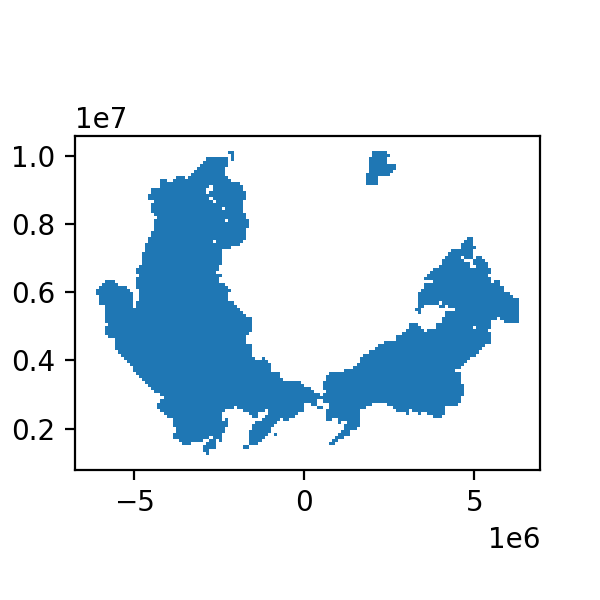

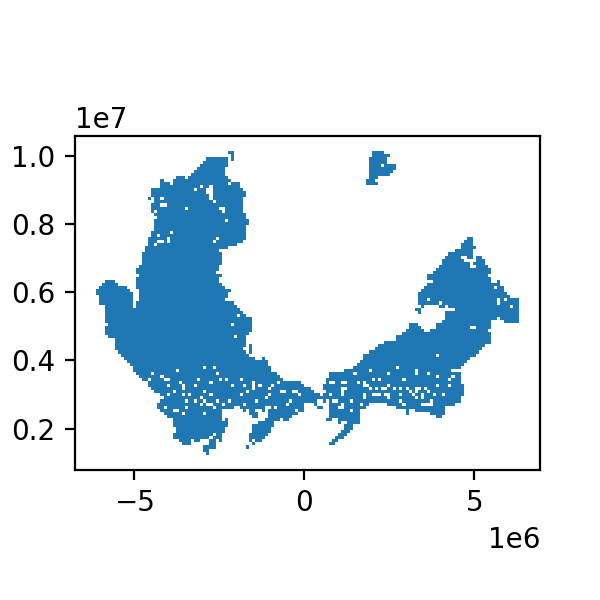

In [149]:
for DICT_FOOTPRINT_PRODUCT in LIST_DICTS:
    
    footprint_fn = f"/projects/my-public-bucket/databank/footprints/footprints_maap_{DICT_FOOTPRINT_PRODUCT['PRODUCT_NAME']}-s3.gpkg"

    product_tindex = pd.read_csv(DICT_FOOTPRINT_PRODUCT['TINDEX_MASTER_FN'])
    boreal_tiles_product = pd.merge(boreal_tiles, product_tindex, on=['tile_num'], how='inner')
    boreal_tiles_product.to_file(footprint_fn, drvier='GPKG')
    
    print(footprint_fn)
    boreal_tiles_product.plot(figsize=(3,3))

In [150]:
boreal_tiles_product.s3_path.to_list()[1]

's3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_map/boreal_agb_2024_v6/Ht_H30_2020/Version2_SD/2024/07/26/01/06/06/733185/boreal_ht_202407261721981063_000009.tif'

In [151]:
# TCC time series years
tcc_years_list = list(range(1984, 2021))

## Path and info on point dataset.

    Will likely be a csv/excel file with list of points in lat/long.
    Notebook has not been tested for using Shapefile here as of 06152022
    
    

In [152]:
# File with objects/points of interest. Data will append to these files
input_fn_list = [
                #'/projects/my-private-bucket/reference/QB_GLCF_VCF.gpkg',
                '/projects/my-private-bucket/reference/liang_plots_high_latitude_additional.geojson',
                # '/projects/my-private-bucket/reference/liang_plots_high_latitude.gpkg',
                # '/projects/my-private-bucket/reference/nfi_plus_20220603.geojson',
                # '/projects/my-private-bucket/reference/eurasia_forest_structure_plots_smrytrees_20240124.gpkg',
                # '/projects/my-private-bucket/reference/Miesner_plots.gpkg',
                # '/projects/my-private-bucket/reference/KolymaRegion_all.gpkg'
                ]

liang_plots_high_latitude_additional


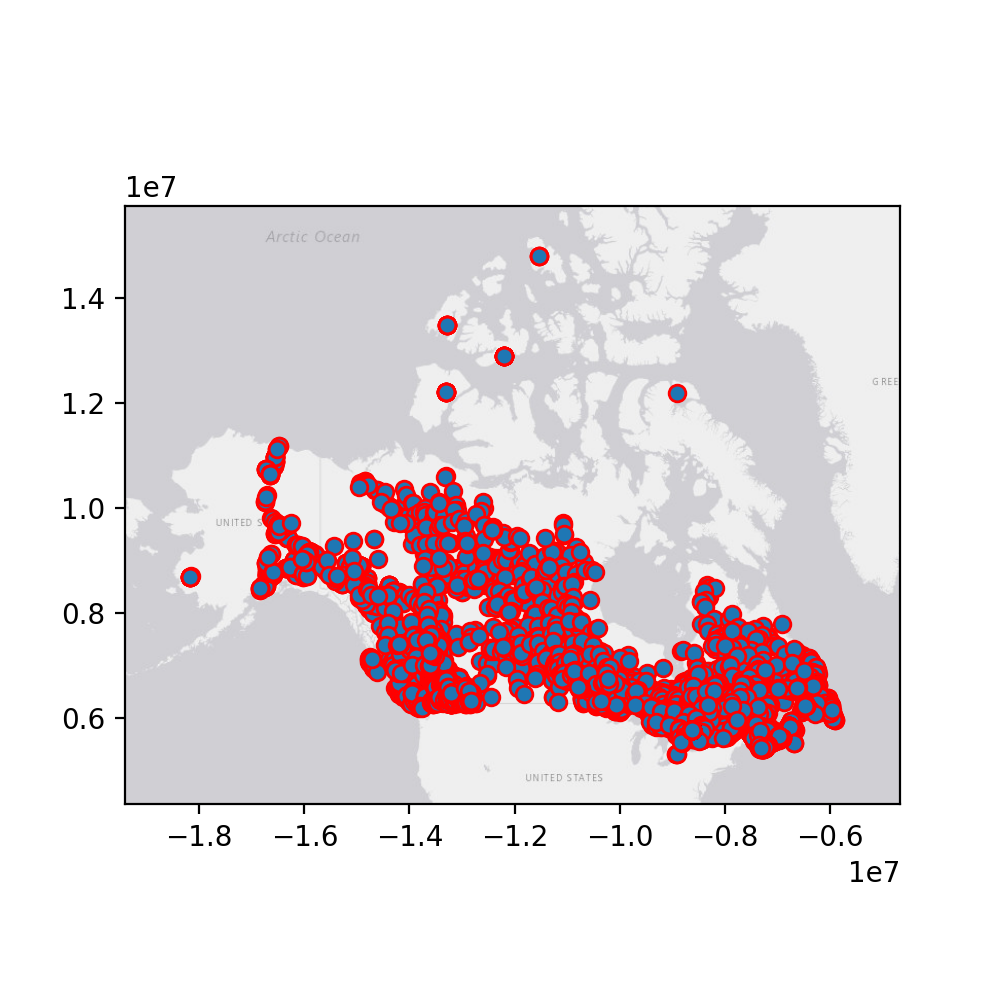

In [153]:
input_points_gdf_list = []

for input_fn in input_fn_list:
    
    print(os.path.splitext(os.path.basename(input_fn))[0])

    if 'csv' in input_fn:
        input_points = pd.read_csv(input_fn)
        input_points = input_points.dropna(subset=['lon', 'lat'])
        input_points[["lon", "lat"]] = input_points[["lon", "lat"]].apply(pd.to_numeric)

        input_points_gdf = gpd.GeoDataFrame(input_points, geometry = gpd.points_from_xy(input_points.lon, input_points.lat))
    else:
        input_points_gdf = gpd.read_file(input_fn)
    
    # Creating a new index file - for consistency across all input gdf files
    input_points_gdf['index1'] = input_points_gdf.index

    input_points_gdf.crs="epsg:4326"
    rows,columns = input_points_gdf.shape
    
    out_fn = f'/projects/my-private-bucket/{os.path.splitext(os.path.basename(input_fn))[0]}.gpkg'
    
    if not os.path.isfile(out_fn):
        'Writing to geopackage...'
        input_points_gdf.to_file(out_fn, driver='GPKG')
        print("There are {} points with {} columns in the input.\n".format(rows, columns))
    
    input_points_gdf_list.append(input_points_gdf)

    if False:
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        ##Change for better representation of world map(Set for Siberia now)
        ax = world.cx[-180:180, 40:90].to_crs(3995).plot(color='white',edgecolor='black')
        print("Input point locations")
        ax = input_points_gdf.to_crs(3995).plot(ax=ax, color='red')

    if True:
        ax = input_points_gdf.to_crs(3857).plot(figsize=(5, 5), edgecolor='red')
        plt.margins(y=0.1, x=0.1)
        ctx.add_basemap(ax,  source="http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}")

## Input the raster tile footprints
Raster Geopackage Information if working with Tiled Rasters

In [197]:
# ft_list = [
#    # '/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_L30_2020-s3.gpkg',
#    # '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_L30_2020-v2022-s3.gpkg',
#    # '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_L30_2020-v2023-local-training-s3.gpkg',
#     '/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_H30_2020-s3.gpkg',
#     '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2020-s3.gpkg'
#           ]
# for footprint_fn in ft_list:
#     footprint_gdf = gpd.read_file(footprint_fn)

#     print("Raster tile footprints")
#     #footprint_gdf.to_crs(3995).plot(edgecolor ='green', alpha=0.1, color=None)
#     print(footprint_gdf.columns)

## **Provide input raster set of information with a dictionary
    You may need to add new parameters to the raster dictionary based on the rasters being used

In [13]:
dict_list = [
#     {'location':'local', #'local' or 's3'
#      'data_dir': "/adapt/nobackup/people/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio/",
#      'file_name': "wc2.0_bio_30s_18.tif",
#      'multi_band': False,
#      'is_tiled': False, #determines if a point by point extraction is needed
#      's3_url_prefix': None,
#      'data_source': 'worldclim-adapt',
#      'data_name': 'Worldclim18', # The column name in the point gdf for the raster values. 
#      'aws_credential_fn': None
#     },  
#     # TerraPulse Stand Age tiles
#     {'location':'local',  #'local' or 's3'
#      'data_dir': "/adapt/nobackup/people/pmontesa/userfs02/data/standage/Boreal_stand_age_v3",
#      'file_name': None, # filename will be a combination of the "data_dir" parameter and "location" value in the raster gdf if using relative paths.
#      'multi_band': False,
#      'is_tiled': True,
#      's3_url_prefix': None,
#      'data_source': 'terrapulse-adapt',
#      'data_name': 'terrapulse_standage',
#      'aws_credential_fn': None
#     },
]


### Use dictionary for TCC2020 to get yearly TCC values

In [14]:
dict_tcc = { 
    # TerraPulse unclipped annual boreal TCC
     'location':'s3',  #'local' or 's3'
     'data_dir': None,
     'file_name': None, # filename will be a combination of the "data_dir" parameter and "location" value in the raster gdf if using relative paths.
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn' : '/projects/my-public-bucket/databank/footprints/footprints_terrapulse-pub-data_boreal-tcc-unclipped-2020.gpkg',
     'drop_cols_list': ['footprint_name', 'path', 'file', 'area_km2', 'area_ha', 'tile_num', 's3_path'],
     's3_url_prefix': None,
     'data_source': 'terrapulse-s3',
     'data_name': 'value_tcc2020',
     'aws_credential_fn': None
    }
   # TerraPulse boreal-pub-data: Stand Age tiles
dict_age = {'location':'s3',  #'local' or 's3'
     'data_dir': None,
     'file_name': None, # filename will be a combination of the "data_dir" parameter and "location" value in the raster gdf if using relative paths.
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg',
     'drop_cols_list': ['footprint_name', 'path', 'file', 'tile_num','s3_path'],
     's3_url_prefix': None,
     'data_source': 'terrapulse-s3',
     'data_name': 'value_standage2020',
     'aws_credential_fn': None
    }
dict_ht_L30_2020 = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_L30_2020-s3.gpkg',
     'drop_cols_list': ['file', 'tile_num', 'tile_version', 'tile_group', 'map_version','Unnamed: 0',  's3_path', 'local_path','creation time'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_ht_L30_2020',
     'aws_credential_fn': None
    }
dict_AGB_L30_2020_v2022 = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_L30_2020-v2022-s3.gpkg',
     'drop_cols_list': ['file', 'tile_num', 'tile_version', 'tile_group', 'map_version','Unnamed: 0',  's3_path', 'local_path'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_AGB_L30_2020-v2022',
     'aws_credential_fn': None
    }
dict_AGB_L30_2020_v2023_local = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_L30_2020-v2023-local-training-s3.gpkg',
     'drop_cols_list': ['file', 'tile_num', 'tile_version', 'tile_group', 'map_version','Unnamed: 0',  's3_path', 'local_path','creation time'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_AGB_L30_2020-v2023-local',
     'aws_credential_fn': None
    }
dict_Ht_H30_2020 = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_H30_2020-s3.gpkg',
     'drop_cols_list': ['file', 'tile_num', 'tile_version', 'tile_group', 'map_version','Unnamed: 0',  's3_path', 'local_path','creation time'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_ht_H30_2020',
     'aws_credential_fn': None
    }
dict_AGB_H30_2020 = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2020-s3.gpkg',
     'drop_cols_list': ['file', 'tile_num', 'tile_version', 'tile_group', 'map_version','Unnamed: 0',  's3_path', 'local_path'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_AGB_H30_2020',
     'aws_credential_fn': None
    }
# ESA Worldcover v1 2020
dict_esawc = {'location': 's3',
     'data_dir': None,
     'file_name': None, 
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
     'drop_cols_list': ['footprint_name', 'path', 'file', 's3_path'],
     's3_url_prefix': None,
     'data_source': 'maap-s3',
     'data_name': 'value_esawc2020',
     'aws_credential_fn': None
    }

### Update additional dicts with year specific strings

In [15]:
dict_Ht_H30_2019  = {**dict_Ht_H30_2020,  'data_name': 'value_ht_H30_2019',  'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_Ht_H30_2019-s3.gpkg'}
dict_AGB_H30_2019 = {**dict_AGB_H30_2020, 'data_name': 'value_AGB_H30_2019', 'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2019-s3.gpkg'}
dict_AGB_H30_2021 = {**dict_AGB_H30_2020, 'data_name': 'value_AGB_H30_2021', 'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2021-s3.gpkg'}
dict_AGB_H30_2022 = {**dict_AGB_H30_2020, 'data_name': 'value_AGB_H30_2022', 'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2022-s3.gpkg'}
dict_AGB_H30_2023 = {**dict_AGB_H30_2020, 'data_name': 'value_AGB_H30_2023', 'footprint_fn': '/projects/my-public-bucket/databank/footprints/footprints_maap_AGB_H30_2023-s3.gpkg'}

### Functions used to perform the Extraction
    Multiband support has not been implemented. Separate location gdf has also not been implemented

In [16]:
# sampling rasters with atl_subset points
#coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
#gdf[list(src.descriptions)] = [x for x in src.sample(coord_list)]
#gdf[list(src2.descriptions)] = [x for x in src2.sample(coord_list)]

def do_s3_point_query(s3_url, gdf, raster_data_name, bandnum=1, ANON=True, PROFILE_NAME='boreal_pub', DEBUG=False):
    import rasterio
    if ANON:
        session = rasterio.env.Env(AWS_NO_SIGN_REQUEST='YES')
    else:
        session = rasterio.env.Env(profile_name=PROFILE_NAME)
    with session:
        with rasterio.open(s3_url, mode='r') as dataset:
            if DEBUG:
                print(f'raster dataset indexes: {dataset.indexes}')
            new_gdf = reproject_gdf_to_rio_ds(gdf, dataset)
            coord_list = [(x,y) for x,y in zip(new_gdf['geometry'].x , new_gdf['geometry'].y)]
            if DEBUG:
                print(coord_list)
                
            # Sample the dataset at this point
            # return the first value associated with the input bandnum
            new_gdf[raster_data_name] = [x for x in dataset.sample(coord_list)][0][bandnum-1]
            if DEBUG:
                print(new_gdf.columns)
            return new_gdf

# def rio_open_aws_r(session, url, gdf):
#     with session:
#         with rio.open(url) as ras:
#             new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
#             new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) 
#             return new_gdf

def do_point_query(new_gdf, ras_fn):
    return point_query(new_gdf,ras_fn, interpolate='nearest')

def get_transformation(ras_fn, gdf):
    ras=rio.open(ras_fn)
    ras_crs=ras.crs
    ras.close()
    return pyproj.Transformer.from_crs(gdf.crs, ras_crs, always_xy=True).transform

def reproject_gdf_to_rio_ds(gdf, rio_ds):
        ras_crs=rio_ds.crs
        gdf_crs=gdf.crs
        return gdf.to_crs(ras_crs)

def clip_and_join(gdf,ras_gdf):
    """
    When working with the tiled raster this function is called to remove the raster tiles from the raster_gdf that don't overlap the points. 
    The Raster paths are then joined with the (point) gdf to get the raster tile path corresponding to each point.
    All functions assume raster path info is stored in column named "location"
    """
    overlaps=gpd.clip(ras_gdf, gdf,keep_geom_type=True)
    gdf=gpd.sjoin(gdf,overlaps, how="left")
    gdf.sindex
    overlaps=None
    has_joined=True
    return gdf,has_joined

def ExtractUntiledRaster(gdf,ras_dict):
    """For untiled rasters, the gdf just needs to be reprojected to the raster projection, then the point_query function takes in 
    the reprojected gdf and the path to the global raster (eg. Worldclim files)"""
    
    if ras_dict['location'] == 'local':
        print("Raster is an ADAPT untiled raster")
        #Open Raster from local source
        ras_fn=os.path.join(ras_dict['data_dir'],ras_dict['file_name'])
        ras=rio.open(ras_fn)
        new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
        new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) #Main command to extract ras values. For untiled takes reprojected df and global raster path
        return new_gdf

    elif ras_dict['location'] == 's3':
        print("Raster is an S3 untiled raster")
        session = rasterio.env.Env(profile_name='')
        url = os.path.join(ras_dict['data_dir'],ras_dict['file_name'])
        with session:
            with rio.open(url) as ras:
                new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
                new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) 
                return new_gdf
        
def ExtractTiledRaster(gdf,ras_dict, tcc_year=None, bandnum=1, DEBUG=False):
    
    """ For the tiled rasters, the point_query function must work on a point by point basis based on the column in the gdf pointing to the
    raster location. Each point is reprojected to the specific raster underneath it, and point_query takes in the reprojected point geom
    and the path to the raster tile"""
    
    if ras_dict['location'] == 'local':
        print("Raster is an ADAPT tiled raster")
        n=0
        nnan=0
        value_list=[]
        for idx,point in gdf.iterrows():
            n+=1
            if type(point.location) is float:
                value_list.append(np.nan)
                nnan+=1
            else:
                ras_fn=os.path.join(ras_dict['data_dir'],str(point.location))

                new_point_geom=shapely.ops.transform(get_transformation(ras_fn, gdf), point.geometry)
                value = do_point_query(new_point_geom, ras_fn) #Main command to extract ras value. For tiled raster works point by point. Takes reprojected point geom and raster path
                value_list.append(value)
            
        gdf[ras_dict['data_name']]=value_list
        print("There were {} NaN filenames out of {}".format(nnan,n))
        
    elif ras_dict['location'] == 's3':
        if DEBUG:
            print("Raster is an S3 tiled raster")
            print(f"GDF shape: {gdf.shape}")
        new_gdf_list = []
        col_name = ras_dict['data_name']
        for idx,point in gdf.iterrows():
            if DEBUG:
                print(point.index1)
            if isinstance(point.s3_path, str):
                ras_fn = point.s3_path
                #col_name = ras_dict['data_name']

                if tcc_year is not None:
                    if DEBUG:
                        print(ras_fn)
                    ras_fn = ras_fn.replace('y2020', 'y'+str(tcc_year))
                    col_name = ras_dict['data_name'].replace('tcc2020', 'tcc'+str(tcc_year))
                    
                if DEBUG:
                    #print(gdf.iloc[[idx]])
                    print(ras_fn)
                    print(col_name)
                    print(gdf.columns)
                    
                new_gdf = do_s3_point_query(ras_fn, gdf.iloc[[idx]], col_name, ANON=True, bandnum=bandnum, DEBUG=DEBUG)
                
                if DEBUG:
                    print(new_gdf.columns)
            else:
                # This adds nan to a point that is outside of the raster
                new_gdf = gdf.iloc[[idx]]
                new_gdf[col_name] = np.nan  
                if DEBUG:
                    print('Point is outside of raster extent...')
                    print(new_gdf.columns)
                #continue
                
            new_gdf_list.append(new_gdf.to_crs(gdf.crs))
            
        gdf = pd.concat(new_gdf_list)
    
    return gdf

## Function to extract a tiled covar by year
    Use for time series stored as similarly name individual rasters, as well as any indiv raster
    Uses year arg to specify the s3 path to the year-specific tile

In [17]:
def run_extract_tiled_covar_year(input_points_gdf, raster_dict=None, tcc_year=None, bandnum=1, has_joined=False, DEBUG=False):
    
    '''
    Function formulated to extract yearly TCC raster values on s3 to points in a geodataframe
    
    ras_dict : a dictionary of tcc2020 raster location, name, and raster footprint gpkg path
    input_points_gdf : a geodataframe with geometry that will be reprojected to that of raster tile using the raster footprint geodataframe
    has_joined : if True then no clipping
    
    note : this function can be multithreaded like this:
    from multiprocessing import Pool
    from functools import partial

    with Pool(processes=10) as pool:
        pool.map(partial(run_extract_tiled_raster, raster_dict=<a_dict>, tcc_year=<a_year>), input_points_gdf_list)
    '''
    if tcc_year is None:
        print(f"Extracting from {raster_dict['data_name']}...")
    else:
        print(f'Extracting TCC from {tcc_year}...')
    if raster_dict is None:
        print('Input raster dict is None.')
        return None
    
    #print("\nRunning point extraction for tiled tcc raster for year {}".format(str(tcc_year)))
    if has_joined:
        pass
    else:
        #print("\n\tClipping to get tiles overlapping points and spatially joining with footprint tile extent to get tile path...")
        footprint_gdf = gpd.read_file(raster_dict['footprint_fn'])
        joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)
    
        print(f"Shape of subset of gdf with no s3_path : {joined_points_gdf[~joined_points_gdf['s3_path'].isnull()].shape}")
    if False:
        # Take out the points that didnt overlay with a tile, and reset index
        extracted_points_gdf = ExtractTiledRaster(joined_points_gdf[~joined_points_gdf['s3_path'].isnull()].reset_index(), raster_dict, tcc_year=tcc_year, bandnum=bandnum, DEBUG=DEBUG)
    else:
        print(f"Shape of gdf : {joined_points_gdf.shape}")

        # Take out the points that didnt overlay with a tile, and reset index
        extracted_points_gdf = ExtractTiledRaster(joined_points_gdf.reset_index(), raster_dict, tcc_year=tcc_year, bandnum=bandnum, DEBUG=DEBUG)

    return extracted_points_gdf

# Run extraction: 
#### 1. Loop Extraction  
#### 2. Multiprocess Extraction 
 - a. chunk extraction: with wrapper, melt, and unmelt
 - b. loop extraction with wrapper

In [28]:
OUTDIR = '/projects/my-private-bucket/reference/extracted'
OUTDIR = '/projects/my-public-bucket/databank/extract_from_points'

!mkdir -p $OUTDIR

#### Function: save the extracted data

In [31]:
def save_extracted_data(input_fn, final_gdf, OUTDIR):
    !mkdir -p $OUTDIR

    nowtime = pd.Timestamp.now()
    print(f'Time: {nowtime}')
    nowtime = nowtime.strftime('%Y%m%d')

    out_fn = f'{OUTDIR}/{os.path.splitext(os.path.basename(input_fn))[0]}_s3_{nowtime}.gpkg'
    print(out_fn)
    final_gdf.to_file(out_fn, driver='GPKG')

In [33]:
# Tiled raster datasets
ras_dict_list = [
                 dict_esawc, 
                 dict_age, 
                 dict_tcc,
                 #dict_ht_L30_2020, 
                 #dict_AGB_L30_2020_v2023_local,
                 #dict_Ht_H30_2019,dict_Ht_H30_2020,
                 #dict_AGB_H30_2019,dict_AGB_H30_2020,dict_AGB_H30_2021,dict_AGB_H30_2022,dict_AGB_H30_2023
                 dict_AGB_H30_2020, dict_Ht_H30_2020,
                ]

## Loop Extraction (final, everything except for TCC)  
- keep indiv raster extract results separate - merge later

In [34]:
# %%time
# final_gdf_list = []
# for i, input_points_gdf in enumerate(input_points_gdf_list):
    
#     #input_points_gdf = input_points_gdf[input_points_gdf.group_name == 'Kotuykan River'] # ------ SUBSET
#     #input_points_gdf = input_points_gdf.head(20)
    
#     extracted_points_gdf_LIST = []
#     for ras_dict in ras_dict_list:
#         # Run
#         extracted_points_gdf = run_extract_tiled_covar_year(input_points_gdf, raster_dict=ras_dict, tcc_year=None, bandnum=1, has_joined=False, DEBUG=False)
        
#         # Save indiv
#         input_fn = input_fn_list[i]
#         out_fn = f"{OUTDIR}/{os.path.splitext(os.path.basename(input_fn))[0]}_{ras_dict['data_name']}.gpkg"
#         print(out_fn)
#         extracted_points_gdf.to_file(out_fn, driver='GPKG')
        
#         if False:
#             # Clean: these are dropped - they are joined from the footprints gdf
#             extracted_points_gdf.drop(['index1','index_right'] + ras_dict['drop_cols_list'], axis=1, inplace=True)
#             # Store: each year's product gdf in a list to be concatenated later
#             extracted_points_gdf_LIST.append(extracted_points_gdf)


### Extract and Save
full set still has *problems* (indexing issue) - `some subsets work`

In [202]:
TEST=False

In [203]:
%%time
final_gdf_list = []
for i, input_points_gdf in enumerate(input_points_gdf_list):
    
    #input_points_gdf = input_points_gdf[input_points_gdf.group_name == 'Kotuykan River'] # ------ SUBSET
    if TEST:
        input_points_gdf = input_points_gdf.head(5)
    
    extracted_points_gdf_LIST = []
    
    for ras_dict in ras_dict_list:
        
        ######
        # Run
        extracted_points_gdf = run_extract_tiled_covar_year(input_points_gdf, raster_dict=ras_dict, tcc_year=None, bandnum=1, has_joined=False, DEBUG=False)
        
        
        # Clean: these are dropped - they are joined from the footprints gdf
        extracted_points_gdf.drop(['index1','index_right'] + ras_dict['drop_cols_list'], axis=1, inplace=True, errors='ignore')
        
        # Store: each year's product gdf in a list to be concatenated later
        extracted_points_gdf_LIST.append(extracted_points_gdf)
        
    #
    #THIS IS BAD - MESSED THINGS UP - FIX
    #out_gdf = pd.concat([input_points_gdf]+[gdf.drop_duplicates()[[col for col in gdf.columns if 'value_' in col]] for gdf in extracted_points_gdf_LIST], axis=1)
    
    new_cols_gdf = pd.concat([gdf[[col for col in gdf.columns if 'value_' in col]] for gdf in extracted_points_gdf_LIST], axis=1)
    out_gdf = pd.concat([input_points_gdf.reset_index(), new_cols_gdf], axis=1)
    
    out_gdf.shape
    
    final_gdf = out_gdf.replace('NA', np.nan).replace(255, np.nan)
    
    if not TEST:
        input_fn = input_fn_list[i]
        # Save
        save_extracted_data(input_fn, final_gdf, OUTDIR)
    

Extracting from value_esawc2020...
Shape of subset of gdf with no s3_path : (10646, 8)
Shape of gdf : (10646, 8)
Extracting from value_standage2020...
Shape of subset of gdf with no s3_path : (5348, 9)
Shape of gdf : (10646, 9)
Extracting from value_tcc2020...
Shape of subset of gdf with no s3_path : (8053, 11)
Shape of gdf : (10659, 11)
Extracting from value_AGB_H30_2020...
Shape of subset of gdf with no s3_path : (10602, 12)
Shape of gdf : (10646, 12)
Extracting from value_ht_H30_2020...
Shape of subset of gdf with no s3_path : (10006, 12)
Shape of gdf : (10646, 12)
Time: 2024-08-02 12:05:24.163354
/projects/my-public-bucket/databank/extract_from_points/liang_plots_high_latitude_additional_s3_20240802.gpkg
CPU times: user 20min 21s, sys: 1min 36s, total: 21min 57s
Wall time: 6h 6min 1s


#### ESA Worldcover v1 2020
Manual: https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf ; pg 13

In [55]:
esawc2020_palette = {0:"#ffffff", 10:"#006400", 20:"#ffbb22", 30:"#ffff4c", 40:"#f096ff", 50:"#fa0000", 60:"#b4b4b4", 70:"#f0f0f0", 80:"#0064c8", 90:"#0096a0", 95:"#00cf75", 100:"#fae6a0"}
esawc2020_names =   {0:"NoData", 10:"Trees", 20:"Shrubs", 30:"Grass", 40:"Crops", 50:"Built-up", 60:"Barren / Sparse", 70:"Snow / Ice", 80:"Water", 90:"Herb. wetland", 95:"Mangroves", 100:"Moss / Lichen"}

### A couple extractions from Version 2 AGB and Height

In [126]:
#final_gdf = gpd.read_file('/projects/my-public-bucket/databank/extract_from_points/liang_plots_high_latitude_s3_20240527.gpkg')
# Set of 152
liang_gdf_20240727 = gpd.read_file('/projects/my-public-bucket/databank/extract_from_points/liang_plots_high_latitude_s3_20240727.gpkg')
# Set of > 10k
liang_gdf_20240802 = gpd.read_file('/projects/my-public-bucket/databank/extract_from_points/liang_plots_high_latitude_additional_s3_20240802.gpkg')
#liang_gdf_20240802.hist('value_AGB_H30_2020', bins=50, figsize=(5,3))

In [127]:
from plotnine import *

In [158]:
input_points_gdf.cx[-56.11232:-56.11230, 49.23499:49.23500].drop_duplicates(['geometry'])

,Data_ID,geometry,index1
8384,8385,POINT (-56.11231 49.23500),8384


<Axes: ylabel='Frequency'>

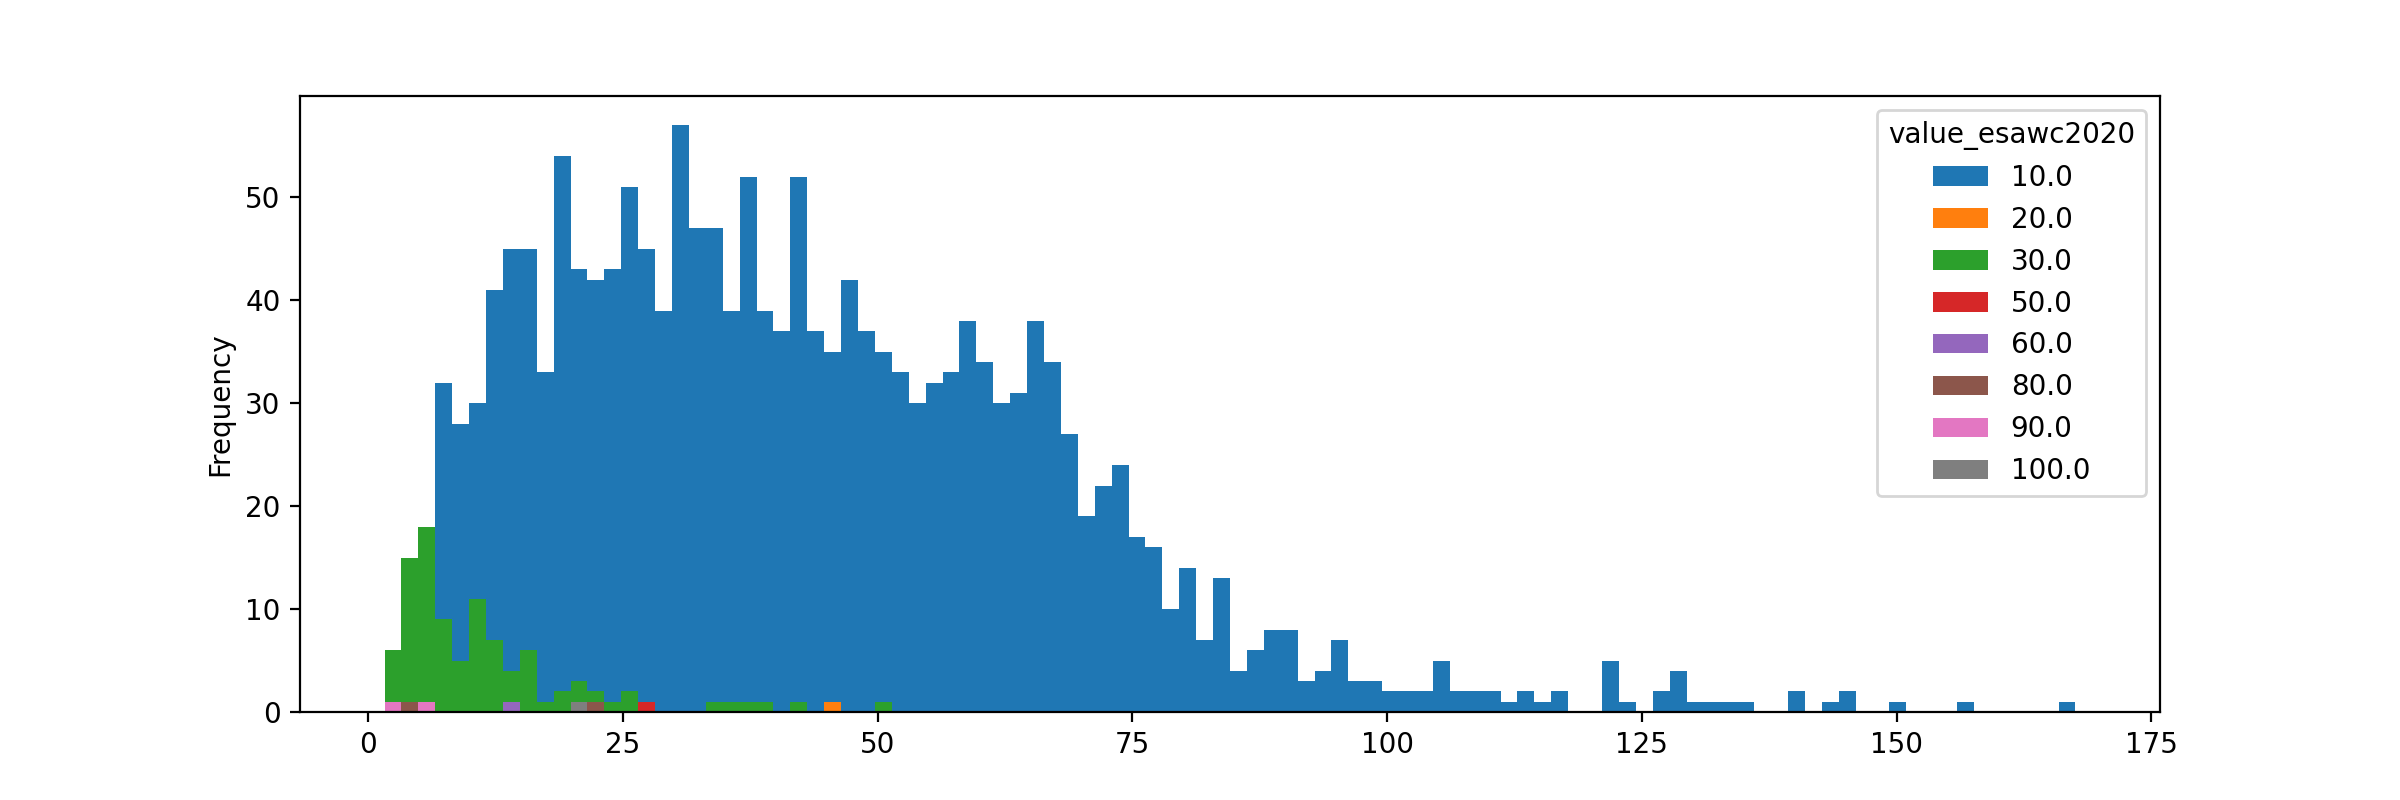

In [159]:
# Set of >10k
liang_gdf_20240802.dropna().drop_duplicates(['geometry']).pivot(columns="value_esawc2020", values="value_AGB_H30_2020").plot.hist(bins=100, figsize=(12,4))

In [166]:
liang_gdf_20240802[liang_gdf_20240802.value_esawc2020.isin([50,60])].drop_duplicates(['geometry']).shape

(24, 9)

### An extraction prior to Version 2

<Axes: ylabel='Frequency'>

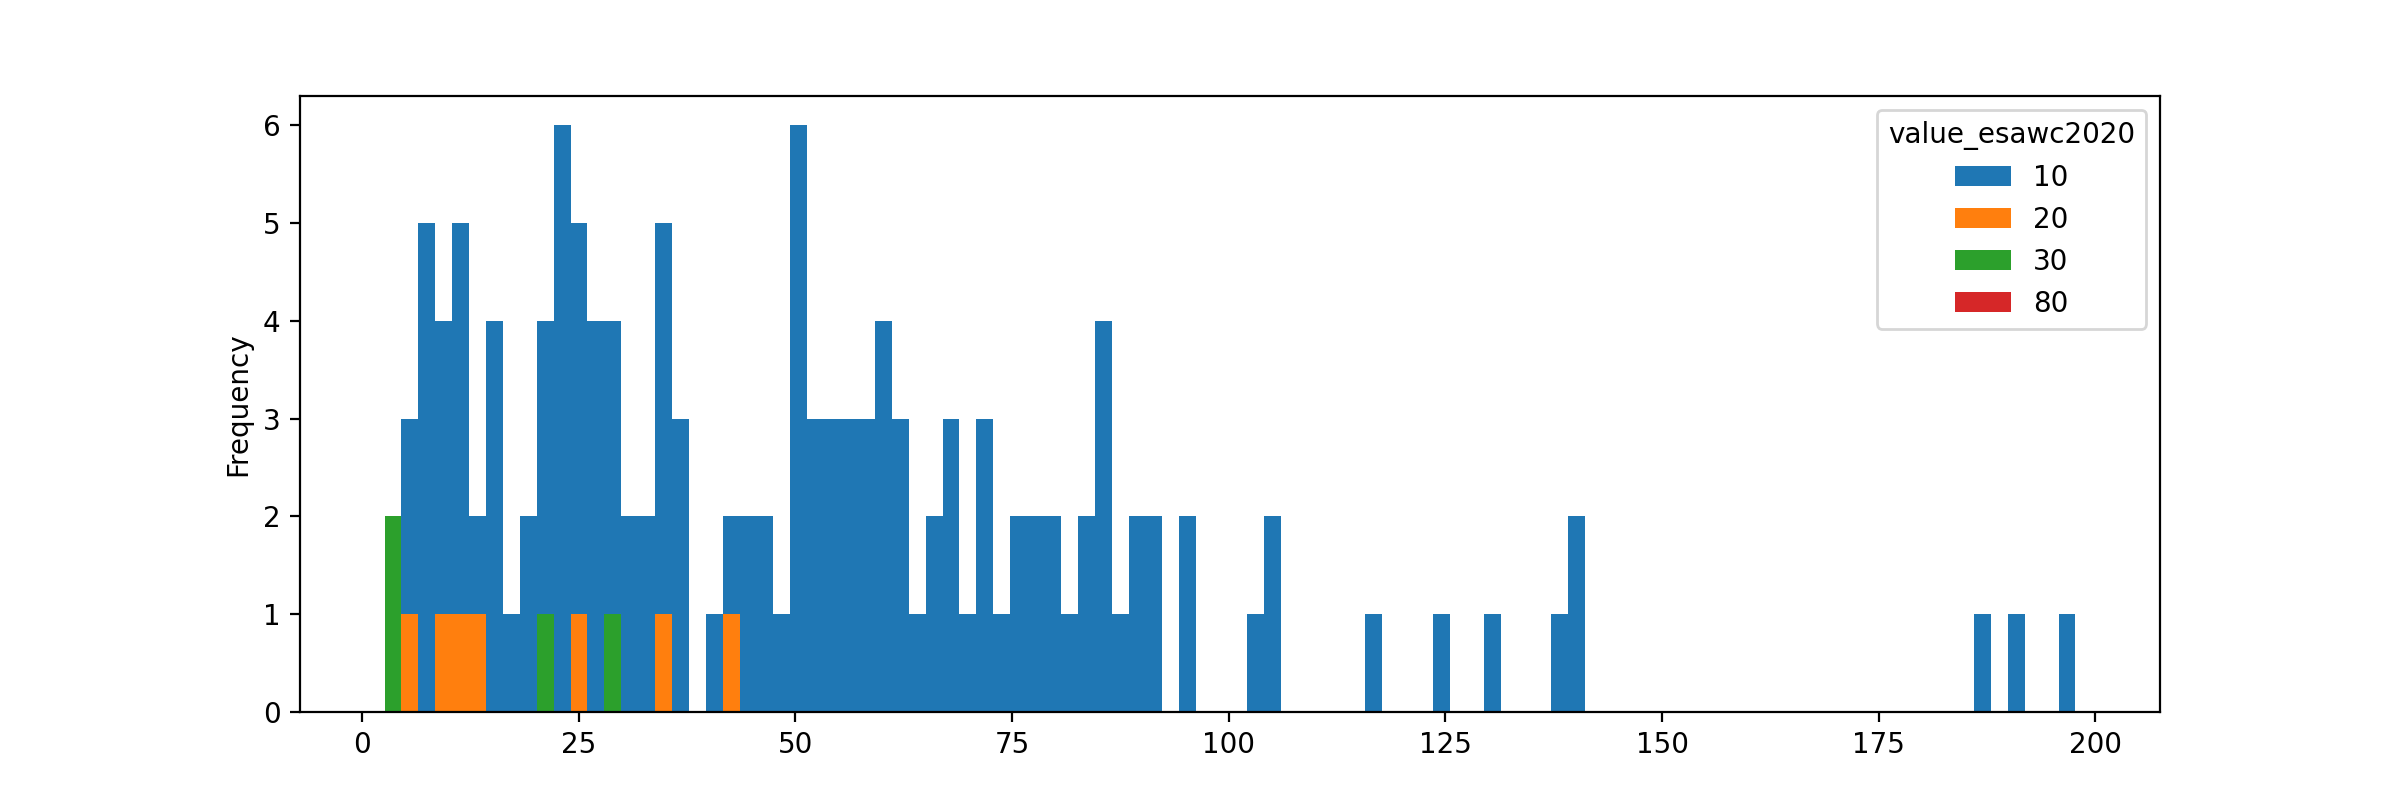

In [129]:
liang_gdf_20240528 = gpd.read_file('/projects/my-public-bucket/databank/extract_from_points/liang_plots_high_latitude_s3_20240528.gpkg')
liang_gdf_20240528.pivot(columns="value_esawc2020", values="value_AGB_H30_2020").plot.hist(bins=100, figsize=(12,4))

In [130]:
# Put the prior extraction onto the current one for comparison - both have 152 sites
liang_gdf_20240727['value_AGB_H30_2020_20240528'] = liang_gdf_20240528.value_AGB_H30_2020

In [177]:
liang_gdf_20240802.tail(5000).head(2).info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 5659 to 5660
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               2 non-null      float64 
 1   Data_ID             2 non-null      float64 
 2   index1              2 non-null      float64 
 3   value_esawc2020     2 non-null      float64 
 4   value_standage2020  0 non-null      float64 
 5   value_tcc2020       0 non-null      float64 
 6   value_AGB_H30_2020  2 non-null      float64 
 7   value_ht_H30_2020   2 non-null      float64 
 8   geometry            2 non-null      geometry
dtypes: float64(8), geometry(1)
memory usage: 276.0 bytes


In [179]:
liang_gdf_20240802['cat_esawc2020'] = liang_gdf_20240802.value_esawc2020.astype('category')

In [185]:
liang_gdf_20240802.dropna().explore(column='cat_esawc2020', cmap='Set1', tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr=' ')

### Extractions from Version 2 was similar to the runs prior at these 152 sites

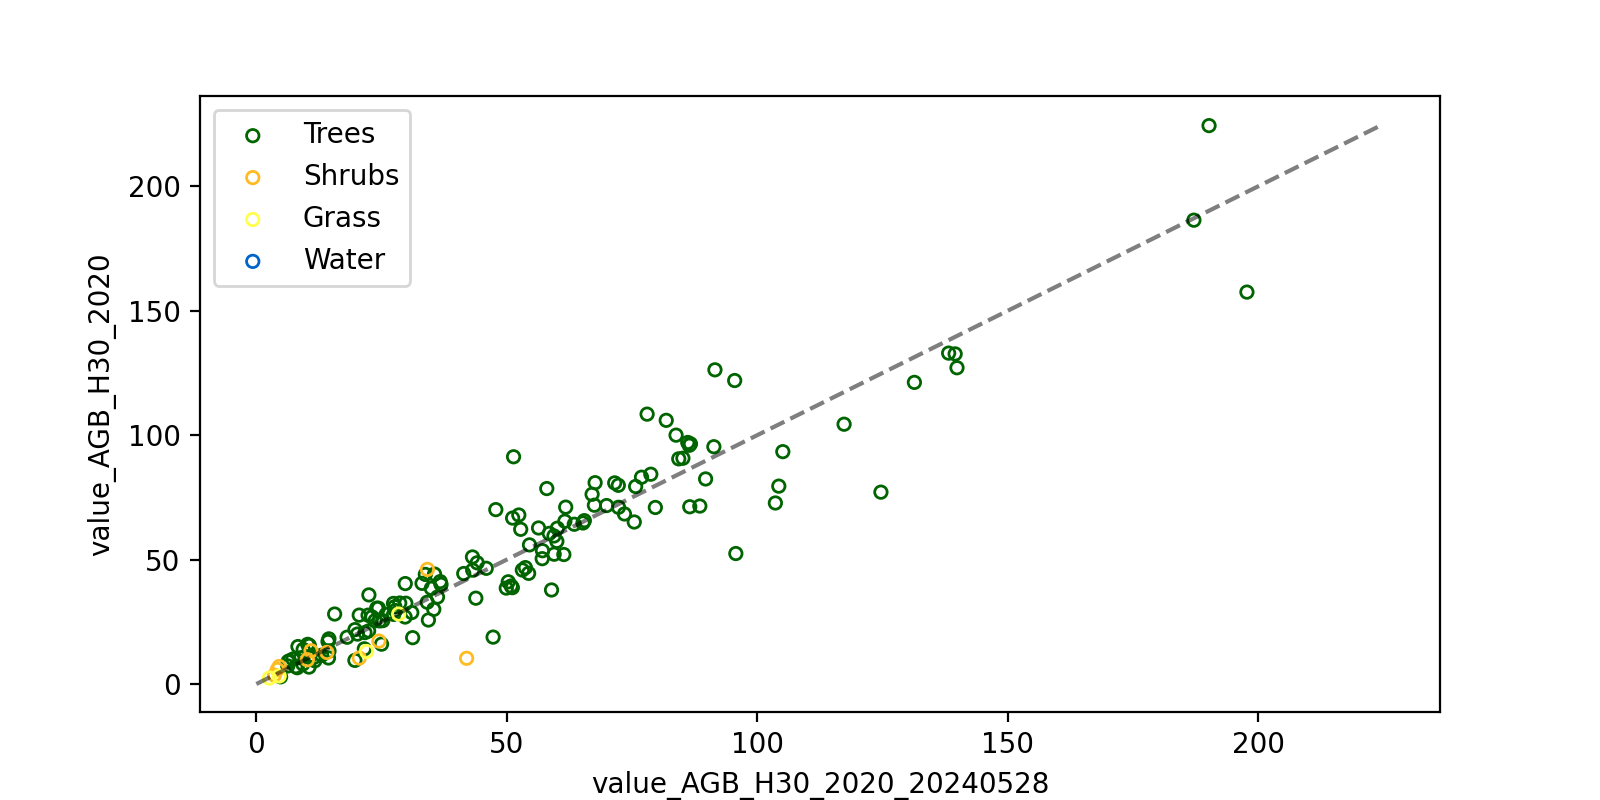

In [132]:
fig, ax = plt.subplots(figsize=(8, 4))

for lc_value, data in liang_gdf_20240727.groupby('value_esawc2020'):

    # Define the color for each group using the dictionary
    lc_color = esawc2020_palette[lc_value]
    lc_label = esawc2020_names[lc_value]

    # Plot each group using the color defined above
    data.plot.scatter(ax=ax, x='value_AGB_H30_2020_20240528', y='value_AGB_H30_2020', label=lc_label, 
                      #s='value_tcc2020', 
                      marker='o', fc='none' , ec=lc_color)

#ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.plot((0,225), (0,225), 'k-', alpha=0.5, zorder=1, linestyle='--')

In [136]:
liang_gdf_20240727['diff_v2_prior'] = liang_gdf_20240727.value_AGB_H30_2020 - liang_gdf_20240727.value_AGB_H30_2020_20240528
liang_gdf_20240727.dropna().explore(column='diff_v2_prior', vmin=-25, vmax=25, cmap='RdBu_r')

# Multiprocess extraction: wrapper to accomodate list of gdfs and list of raster dicts

#### Note: this will only save time if you chunk up the input gdfs `ToDo`

In [238]:
from multiprocessing import Pool
from functools import partial

In [261]:
def wrapper_extract(input_points_gdf, ras_dict):
    if False:
        print("Running 'run_extract_tiled_covar_year' in wrapper...")
    extracted_points_gdf = run_extract_tiled_covar_year(input_points_gdf, raster_dict=ras_dict, tcc_year=None, bandnum=1, has_joined=False, DEBUG=False)
    print(extracted_points_gdf.shape)
    if False:
        # Clean: these are dropped - they are joined from the footprints gdf
        extracted_points_gdf =  extracted_points_gdf.drop(['index1','index_right'] + ras_dict['drop_cols_list'], axis=1, errors='ignore').to_crs(4326)
        print(extracted_points_gdf.shape)
    return extracted_points_gdf

In [262]:
def wrapper_function(args, func):
    """
    Wrapper function to run a given function with two inputs in parallel.

    Parameters:
    - args: Tuple of two lists, where each list contains the inputs for the function.
    - func: The function to be executed with two inputs.

    Returns:
    - result: The result of the function.
    """
    input1, input2 = args
    result = func(input1, input2)
    return result

In [263]:
import numpy as np

### Chunk multiprocess extraction

- `FIXED` by using `melt()` : This produces a `results` list that wont `pd.merge()`  ....  

        Chunk each input gdf in list  
        DO NOT chunk into indiv point gdfs - this will result in LONGER runtime

        30 chunks  of 152 pts = 2+ minutes 
        12 ... 1 min 19sec/16sec
        10 ... 1 min 12sec 
        7 ... 1 min 15sec
        5 ... 1 min 29sec  
        3... 1 min 49sec

In [ ]:
%%time 

tmp_list =[np.array_split(gdf.head(2), 1) for gdf in input_points_gdf_list]
chunked_input_gdf_list = list(itertools.chain(*tmp_list))

# Combine the two lists into a list of tuples of all possible combos of both lists
input_tuples =  list(itertools.product(*[chunked_input_gdf_list, ras_dict_list]))

# Create a partial function with the example_function
partial_function = partial(wrapper_function, func=wrapper_extract)

# Use multiprocessing.Pool to parallelize the computation
with Pool(processes=30) as pool:
    results = pool.map(partial_function, input_tuples)

In [252]:
results[-3]

,level_0,year,geometry,index,value_AGB_H30_2021
0,137,2017,POINT (-80.75332 49.97567),3784,60.912640
1,138,2018,POINT (-80.75319 49.07819),2787,22.518404
2,139,2017,POINT (-81.20111 50.19027),3976,35.669456
3,140,2018,POINT (-80.91313 48.03841),398,65.862999
4,141,2018,POINT (-80.43544 47.57260),3777,105.514595
5,142,2016,POINT (-80.58881 49.22163),3513,66.399162
6,143,2016,POINT (-80.25819 49.50778),3818,24.699776
7,144,2018,POINT (-79.70189 49.68335),3818,41.091122
8,145,2016,POINT (-79.58109 50.07729),3818,39.811802
9,146,2016,POINT (-79.63073 50.32932),4045,33.674229


### Melt the results to put them together
### `ToDo` figure out unmelt after melt:

In [136]:
def melt_df(df):
    return df.melt(id_vars=[col for col in df.columns if not 'value_' in col ], var_name='variable', value_name='value')

In [256]:
results_melted = [melt_df(df) for df in results]

In [260]:
results_melted[5]


,level_0,year,geometry,index,variable,value
0,0,2017,POINT (-143.15595 63.27887),1636,value_AGB_H30_2020,29.686300
1,1,2017,POINT (-143.15525 63.27930),1636,value_AGB_H30_2020,19.680870
2,2,2017,POINT (-143.15435 63.27898),1636,value_AGB_H30_2020,23.688751
3,3,2017,POINT (-130.42675 53.93775),1017,value_AGB_H30_2020,81.807640
4,4,2017,POINT (-129.48242 53.60866),1155,value_AGB_H30_2020,58.915291
5,5,2017,POINT (-129.18005 53.61719),1155,value_AGB_H30_2020,NaN
6,6,2017,POINT (-128.56398 53.45197),1130,value_AGB_H30_2020,139.843491
7,7,2017,POINT (-127.96949 53.64360),1130,value_AGB_H30_2020,197.711868
8,8,2018,POINT (-128.14505 57.06090),1472,value_AGB_H30_2020,67.613510
9,9,2017,POINT (-128.32226 54.53772),1598,value_AGB_H30_2020,89.667610


In [255]:
gdf_melted = pd.concat(results_melted)
gdf_melted.tail()

,index,year,geometry,variable,value,level_0
10,1769,2017,POINT (-76.13201 44.46730),value_AGB_H30_2023,105.123589,147.0
11,1362,2017,POINT (-71.41800 46.75529),value_AGB_H30_2023,112.881142,148.0
12,1015,2017,POINT (-69.75565 47.13173),value_AGB_H30_2023,61.872395,149.0
13,960,2017,POINT (-68.98676 47.88078),value_AGB_H30_2023,100.332985,150.0
14,960,2017,POINT (-68.80388 47.75087),value_AGB_H30_2023,93.151230,151.0


In [250]:
gdf_melted = pd.concat([df.drop('level_0', axis=1, errors='ignore') for df in results_melted])
gdf_melted.tail()

,index,year,geometry,variable,value
10,1769,2017,POINT (-76.13201 44.46730),value_AGB_H30_2023,105.123589
11,1362,2017,POINT (-71.41800 46.75529),value_AGB_H30_2023,112.881142
12,1015,2017,POINT (-69.75565 47.13173),value_AGB_H30_2023,61.872395
13,960,2017,POINT (-68.98676 47.88078),value_AGB_H30_2023,100.332985
14,960,2017,POINT (-68.80388 47.75087),value_AGB_H30_2023,93.151230


In [249]:
z = gdf_melted.pivot(index='index',columns = 'variable', values = 'value')
z.head()

ValueError: Index contains duplicate entries, cannot reshape

In [161]:
# Unmelt
final_gdf = (
    gdf_melted
    .melt()
    .assign(variable=lambda x: x['variable'] + x.groupby('variable').cumcount().add(1).astype(str))
    .set_index('variable')
    .T
    .reset_index(drop=True)
    .rename_axis(None, axis=1)
)

ValueError: value_name (value) cannot match an element in the DataFrame columns.

In [160]:
# Unmelt - doesnt work
final_gdf = gdf_melted.groupby(['index','year','geometry','variable'])['value'].aggregate('max').unstack().reset_index()
final_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               456 non-null    int64   
 1   year                456 non-null    int64   
 2   geometry            456 non-null    geometry
 3   value_AGB_H30_2020  151 non-null    float64 
 4   value_esawc2020     152 non-null    float64 
 5   value_ht_H30_2020   151 non-null    float64 
 6   value_standage2020  129 non-null    float64 
dtypes: float64(4), geometry(1), int64(2)
memory usage: 25.1 KB


In [115]:
#### Merge results - in `index` - be careful
#### check to make sure results are merged as expected
# from functools import reduce
# final_gdf = reduce(lambda left,right: pd.merge(left,right.drop(['geometry','year','level_0','index'], axis=1, errors='ignore').reset_index(), on=['index'],how='left' ), results)

In [29]:
final_gdf.drop('value_standage2020', inplace=True, axis=1)

In [177]:
final_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               456 non-null    int64   
 1   year                456 non-null    int64   
 2   geometry            456 non-null    geometry
 3   value_AGB_H30_2020  151 non-null    float64 
 4   value_esawc2020     152 non-null    float64 
 5   value_ht_H30_2020   151 non-null    float64 
 6   value_standage2020  129 non-null    float64 
dtypes: float64(4), geometry(1), int64(2)
memory usage: 25.1 KB


#### Save the extracted data

In [ ]:
save_extracted_data(input_fn, final_gdf, OUTDIR)

### b. Loop extraction with wrapper 
loop over list of input gdfs, run extraction from raster dicts in parallel

In [ ]:
%%time

final_gdf_list = []

# Do for all point gdfs
for input_points_gdf in input_points_gdf_list:
    
    #input_points_gdf = input_points_gdf[input_points_gdf.group_name == 'Kotuykan River'].head(10) # ------ SUBSET
    if TEST:
        input_points_gdf.head()
    
    with Pool(processes=30) as pool:
        extracted_points_gdf_LIST = pool.map(partial(wrapper_extract, input_points_gdf), ras_dict_list[0:])
        
    #out_gdf = pd.concat([input_points_gdf]+[gdf.drop_duplicates()[[col for col in gdf.columns if 'value_' in col]] for gdf in extracted_points_gdf_LIST], axis=1)
    #out_gdf = pd.concat([input_points_gdf]+[gdf[[col for col in gdf.columns if 'value_' in col]] for gdf in extracted_points_gdf_LIST], axis=1)
    out_gdf = pd.concat(extracted_points_gdf_LIST)
    final_gdf = out_gdf.replace('NA', np.nan).replace(255, np.nan)
    final_gdf_list.append(final_gdf)


Running 'run_extract_tiled_covar_year' in wrapper...Running 'run_extract_tiled_covar_year' in wrapper...Running 'run_extract_tiled_covar_year' in wrapper...Running 'run_extract_tiled_covar_year' in wrapper...



Extracting from value_esawc2020...Extracting from value_standage2020...Extracting from value_ht_H30_2020...Extracting from value_AGB_H30_2020-v2022...



Shape of subset of gdf with no s3_path : (152, 12)
Shape of gdf : (152, 12)
Shape of subset of gdf with no s3_path : (129, 9)
Shape of gdf : (152, 9)
Shape of subset of gdf with no s3_path : (152, 8)
Shape of gdf : (152, 8)


/opt/conda/envs/pangeo/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/pangeo/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/pangeo/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [155]:
final_gdf.head(10)

,site,group_name,year,glas_campaign,glas_ndx,glas_shot,rad_m,num_plots,plot_area_m2,canopy_closure_perc,...,DBH_se,canopy_area_m2_sum,N_dens_ha,tcc_perc,geometry,index1,value_esawc2020,value_standage2020,value_ht_L30_2020,value_AGB_L30_2020-v2023-local
0,1,Amur River,2002,,,NaN,9.8,1.0,301.718558,NaN,...,NaN,NaN,NaN,NaN,POINT (123.09014 53.88483),0,10,NaN,14.533210,58.516788
1,10,Amur River,2002,,,NaN,9.8,1.0,301.718558,NaN,...,NaN,NaN,NaN,NaN,POINT (122.91742 53.60714),1,10,NaN,11.374351,63.009079
2,1076302264_19,Tahe,2006,L3,1076302264,19.0,7.5,4.0,706.858347,NaN,...,0.13,0.0,NaN,NaN,POINT (125.28197 52.54544),2,10,NaN,16.548603,92.409081
3,1076302264_20,Tahe,2006,L3,1076302264,20.0,7.5,4.0,706.858347,NaN,...,0.20,0.0,NaN,NaN,POINT (125.28158 52.54390),3,10,NaN,16.933165,85.969940
4,1076302284_12,Tahe,2006,L3,1076302284,12.0,7.5,4.0,706.858347,NaN,...,0.18,0.0,NaN,NaN,POINT (125.25319 52.43282),4,10,NaN,17.189137,74.053711


### Save the extracted data

In [118]:
OUTDIR = '/projects/my-public-bucket/databank/extract_from_points'
!mkdir -p $OUTDIR

for i, final_gdf in enumerate(final_gdf_list):
    input_fn = input_fn_list[i]
    
    save_extracted_data(input_fn, final_gdf, OUTDIR)

/projects/my-public-bucket/databank/extract_from_points/Miesner_plots_s3_esa_agb_age_ht.gpkg


# Time-series of TCC extraction
### Loop over years of multi-raster time series (TCC) (_final approach that worked_)
This takes ~ 50 minutes  
Requires dropping of duplicates and resetting of index for each gdf in output list

In [13]:
input_fn_list

['/projects/my-private-bucket/reference/QB_GLCF_VCF.gpkg']

# Extract TCC for all years with multiprocessing

This is where the magic happens for an input file that has some TCC reference

In [21]:
%%time
extracted_tcc_list = []
for i, input_fn in enumerate(input_fn_list):
    
    print(input_fn)
    
    #
    # Set wrapper with input gdf
    #
    def wrapper_tcc_year(tcc_year, out_gdf = input_points_gdf_list[i].head(10), raster_dict = dict_tcc):
        return run_extract_tiled_covar_year(out_gdf, raster_dict=dict_tcc, tcc_year=tcc_year, has_joined=False)
    #
    # Use multiprocessing.Pool to parallelize the computation
    #
    with Pool(processes=20) as pool:
        results = pool.map(wrapper_tcc_year, tcc_years_list[-1:])
    #
    # Unpack the results: clean, merge, save
    #
    r_list = []
    for r in results:
        r_list.append(r.drop(['index', 'index1', 'index_right'] + dict_tcc['drop_cols_list'] , axis=1))

    for i, r in enumerate(r_list):

        tcc_col = [col for col in r.columns if 'value_tcc' in col]

        # Replace 255 with NaN
        r[tcc_col[0]].replace(255, np.NaN, inplace=True)

        if i == 0:
            extracted_tcc = r
        else:
            # Use this to check that all rows are corrected assigned to each site -- but you dont want 'site' field duplicated...rm before export to GPKG?
            extracted_tcc = pd.concat([extracted_tcc, r[['site']+tcc_col]], axis=1)

        print(f'{i} {tcc_col} {extracted_tcc.shape}')


    extracted_tcc = extracted_tcc.loc[:,~extracted_tcc.columns.duplicated()].copy() 
    extracted_tcc_list.append(extracted_tcc)

/projects/my-private-bucket/reference/QB_GLCF_VCF.gpkg
Extracting TCC from 2020...
Shape of subset of gdf with no s3_path : (10, 26)
Shape of gdf : (10, 26)


ValueError: x attribute access only provided for Point geometries

In [24]:
input_points_gdf_list[i].explore()

### Save TCC

In [395]:
for i, input_fn in enumerate(input_fn_list):
    extracted_tcc = extracted_tcc_list[i]
    extracted_tcc.to_file(os.path.join('/projects/my-private-bucket/reference/extracted',os.path.basename(os.path.splitext(input_fn)[0]) + '_tcc1984-2020.gpkg'), DRIVER='GPKG')

IndexError: list index out of range

In [ ]:
%%time
if False:
    extracted_points_gdf_LIST = []

    for tcc_year in tcc_years_list:

        # Run:
        extracted_points_gdf = run_extract_tiled_covar_year(out_gdf.head(1), raster_dict=dict_tcc, tcc_year=tcc_year, has_joined=False)
        #has_joined = True
        if False:
            # Clean: these are dropped - they are joined from the footprints gdf
            extracted_points_gdf.drop(['index1', 'index_right'] + dict_tcc['drop_cols_list'] , axis=1, inplace=True)

            # Save: input gdf with the current year's value column
            #extracted_points_gdf.to_file(f'/projects/my-private-bucket/{os.path.splitext(os.path.basename(input_fn))[0]}_s3tp_tcc{tcc_year}.gpkg', driver='GPKG') 

        # Store: each year's tcc gdf in a list to be concatenated later
        extracted_points_gdf_LIST.append(extracted_points_gdf)


## Concatenate the cleaned extraction results

In [17]:
z = pd.concat(extracted_points_gdf_LIST)
z.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7400 entries, 0 to 199
Data columns (total 88 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   index                                    7400 non-null   int64   
 1   Event                                    7400 non-null   object  
 2   Site                                     7400 non-null   object  
 3   Campaign                                 7400 non-null   object  
 4   Area (Federation Subject)                7400 non-null   object  
 5   Area (District)                          7400 non-null   object  
 6   Elevation [m a.s.l.]                     7363 non-null   float64 
 7   PI                                       7400 non-null   object  
 8   Reference                                1554 non-null   object  
 9   Area (Camp Location)                     7400 non-null   object  
 10  lat                          

In [18]:
out_gdf = pd.concat([input_points_gdf]+[gdf.drop_duplicates().reset_index(drop=True)[[col for col in gdf.columns if 'tcc' in col]] for gdf in extracted_points_gdf_LIST], axis=1)
out_gdf.shape

(226, 88)

In [19]:
out_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 88 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Event                                    226 non-null    object  
 1   Site                                     226 non-null    object  
 2   Campaign                                 226 non-null    object  
 3   Area (Federation Subject)                226 non-null    object  
 4   Area (District)                          226 non-null    object  
 5   Elevation [m a.s.l.]                     225 non-null    float64 
 6   PI                                       226 non-null    object  
 7   Reference                                45 non-null     object  
 8   Area (Camp Location)                     226 non-null    object  
 9   lat                                      226 non-null    float64 
 10  lon                           

### Write concatenated output

In [21]:
final_gdf = out_gdf.replace('NA', np.nan).replace(255, np.nan)
final_gdf.to_file(f'/projects/my-private-bucket/{os.path.splitext(os.path.basename(input_fn))[0]}_s3tp_tcc1984-2020.gpkg', driver='GPKG')

#  
#  
# Below is scratch work
#  
#  
### Attempt at multiprocessing

##### Define multiprocessing function - this wont work

In [26]:
from multiprocessing import Pool
from functools import partial
    
def multiprocess_extract(tcc_year, dict_tcc, input_points_gdf_list):

    extracted_points_gdf_list = []
    print(f'Multi-processing extraction of TCC from {tcc_year}...')
    with Pool(processes=10) as pool:
        gdf = pool.map(partial(run_extract_tiled_tcc_year, raster_dict = dict_tcc, tcc_year = tcc_year), input_points_gdf_list)
        return gdf

##### Multiprocess the TCC extraction - Not working correctly -

In [ ]:
%%time

n = 1  #chunk row size

orig_cols = input_points_gdf.columns

extracted_points_gdf = input_points_gd

# This concats the data for a given year (which is chunked for multiprocessing), then builds a list of all the concat'd yearly gdfs
# This list needs to be merged to return 1 gdf with yearly cols of tcc for each point

if False:
    # This one results is tons of duplicates for a few sites
    extracted_points_gdf_list_4_merge = [pd.concat(multiprocess_extract(tcc_year, dict_tcc, [extracted_points_gdf[i:i+n].reset_index() for i in range(0, extracted_points_gdf.shape[0],n)] ) ) for tcc_year in tcc_years_list] 
    
    for idx, gdf in enumerate(extracted_points_gdf_list_4_merge):
        gdf.to_file(f'/projects/my-private-bucket/kolymaregion_s3tp_tcc{tcc_years_list[idx]}.gpkg', driver='GPKG') 

#
#
#
# Loop over list of dictionaries
Use this for other s3/ADAPT datasets that dont need the special data tile finding treatment that the TCC dataset requires

In [ ]:
has_joined=False #Only need to run once, assuming only 1 raster geopackage is needed. Notebook was written with that assumption
tcc_years_list = list(range(1984, 2021))

#Looping through Rasters First;Wont matter for testing
for ras_dict in dict_list:
    
    if not ras_dict['is_tiled']:
        print("\nRunning Point Extraction for {}".format(ras_dict['data_name']))
        extracted_points_gdf = ExtractUntiledRaster(input_points_gdf, ras_dict)
    else:
        #         print("\nRunning Point Extraction for Tiled Raster {}".format(ras_dict['data_name']))
        #         if has_joined:
        #             pass
        #         else:
        #             print("\n\tClipping out Raster tiles not overlapping points Shapefile and Joining")
        #             footprint_gdf = gpd.read_file(ras_dict['footprint_fn'])
        #             joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)

        #         extracted_points_gdf = ExtractTiledRaster(joined_points_gdf, ras_dict, tcc_year=None)

        extracted_points_gdf = run_extract_tiled_tcc_year(input_points_gdf, raster_dict=ras_dict, tcc_year=2019, has_joined=False)
        
    print("\nFinished running Extraction for {}".format(ras_dict['data_name']))

extracted_points_gdf.head() 

In [75]:
joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)
#extracted_points_gdf = ExtractTiledRaster(joined_points_gdf, ras_dict)

g1 = do_s3_point_query( 's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1104/v098/h1104v098/h1104v098_y2020_dat.tif', joined_points_gdf, 'tp_tcc2020', ANON=True, PROFILE_NAME='boreal_pub')
g2 = do_s3_point_query( 's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1104/v098/h1104v098/h1104v098_y2020_dat.tif', joined_points_gdf, 'tp_tcc2020', ANON=True, PROFILE_NAME='boreal_pub')
g = pd.concat([g1,g2])
g

[array([14], dtype=uint8), array([22], dtype=uint8), array([8], dtype=uint8), array([5], dtype=uint8), array([255.])]
[array([14], dtype=uint8), array([22], dtype=uint8), array([8], dtype=uint8), array([5], dtype=uint8), array([255.])]


,site,lat,lon,canopy_cover,canopy_ste,stand_density,density_ste,larch_biomass,biomass_ste,year,...,geometry,index_right,footprint_name,path,file,area_km2,area_ha,tile_num,s3_path,tp_tcc2020
0,1,68.76231,161.23608,15.51,1,0.05,0.03,611.2,431.5,2010,...,POINT (6494436.074 7646028.634),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[14]
1,2,68.76919,161.24397,7.52,0.6,0,0,0,0,2010,...,POINT (6492747.091 7646793.656),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[22]
2,3,68.78801,161.49601,7.86,1.6,0.02,0.02,0.3,0.3,2010,...,POINT (6497397.338 7648886.347),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[8]
3,4,68.7822,161.47642,2.91,0.87,0.01,0.01,0,0,2010,...,POINT (6498306.530 7648240.304),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[5]
4,5,68.7457,161.53402,0.74,0.39,0,0,0,0,2010,...,POINT (6511290.010 7644181.685),8427,h1105v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1105v098_y2020_dat.tif,577.4409,57744.09,3427,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[255.0]
0,1,68.76231,161.23608,15.51,1,0.05,0.03,611.2,431.5,2010,...,POINT (6494436.074 7646028.634),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[14]
1,2,68.76919,161.24397,7.52,0.6,0,0,0,0,2010,...,POINT (6492747.091 7646793.656),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[22]
2,3,68.78801,161.49601,7.86,1.6,0.02,0.02,0.3,0.3,2010,...,POINT (6497397.338 7648886.347),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[8]
3,4,68.7822,161.47642,2.91,0.87,0.01,0.01,0,0,2010,...,POINT (6498306.530 7648240.304),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[5]
4,5,68.7457,161.53402,0.74,0.39,0,0,0,0,2010,...,POINT (6511290.010 7644181.685),8427,h1105v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1105v098_y2020_dat.tif,577.4409,57744.09,3427,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[255.0]


This next section contains a function provided by Paul from Laura Duncansons github, in dealing with icesat2. Looks to extract raster band values to the obs of a geodataframe. 
## **Function to extract values to geodataframe obj**

In [57]:
def extract_value_gdf(r_fn, pt_gdf, bandnames: list, reproject=True, TEST=False):
    """Extract raster band values to the obs of a geodataframe
    """

    print("\tExtracting raster values from: ", r_fn)
    r_src = rio.open(r_fn)
    
    if reproject:
        print("\tRe-project points to match raster...")
        pt_gdf = pt_gdf.to_crs(r_src.crs)
    
    for idx, bandname in enumerate(bandnames):
        bandnum = idx + 1
        if TEST: print("Read as a numpy masked array...")
        r = r_src.read(bandnum, masked=True)
        
        if TEST: print(r.dtype)

        pt_coord = [(pt.x, pt.y) for pt in pt_gdf.geometry]

        # Use 'sample' from rasterio
        if TEST: print("Create a generator for sampling raster...")
        pt_sample = r_src.sample(pt_coord, bandnum)
        
        if TEST:
            for i, val in enumerate(r_src.sample(pt_coord, bandnum)):
                print("point {} value: {}".format(i, val))
            
        if TEST: print("Use generator to evaluate (sample)...")
        pt_sample_eval = np.fromiter(pt_sample, dtype=r.dtype)

        if TEST: print("Deal with no data...")
        pt_sample_eval_ma = np.ma.masked_equal(pt_sample_eval, r_src.nodata)
        #pt_gdf[bandname] = pd.Categorical(pt_sample_eval_ma.astype(int).filled(-1))
        pt_gdf[bandname] = pt_sample_eval_ma.astype(float).filled(np.nan)
        
        #print('\tDataframe has new raster value column: {}'.format(bandname))
        r = None
        
    r_src.close()
    
    print('\tReturning {} points with {} new raster value columns: {}'.format(len(pt_gdf), len(bandnames), bandnames))
    return(pt_gdf)
